In [1]:
###################################################################################################
#
# Copyright (C) 2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch

import matplotlib.patches as patches
import matplotlib.pyplot as plt

#from distiller import apputils, model_summaries

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))

from collections import OrderedDict

import ai8x
from datasets import almond
from utils import object_detection_utils as obj_det_utils
from utils import parse_obj_detection_yaml
import parse_qat_yaml
import torch.nn.functional as F
ai85net_tinierssd_almond = __import__("ai85net-tinierssd-almond")
from PIL import Image
from torchvision import transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
data_path = '../data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=False)
Normalize = ai8x.normalize(args=args)
convert_tensor = transforms.ToTensor()
_, test_set = almond.ALMOND_168_224_get_datasets((data_path, args), load_train=False, load_test=True)


IMAGES ARE EXPECTED TO BE 168x224 !

Generating dataset pickle file from the raw image files...


Total number of processed files: 3013

Test dataset length: 3013



In [120]:
num_classes = 2
#checkpoint_path = "../logs/2023.02.02-194757_NewAlmModel_1p_1a_ALM65_10k_blur_randScale1.2-0.8/qat_best.pth.tar"
#checkpoint_path = "../logs/2023.02.03-173605_NewAlmModel_1p_1a_ALM65_20k_blur_randScale1.2-0.8_lightback/qat_best.pth.tar"
#checkpoint_path = "../logs/2023.02.03-201932_NewAlmModel_1p_1a_ALM65_30k_blur_randScale1.2-0.8_allback/qat_best.pth.tar"
#checkpoint_path = "../logs/2023.02.06-184210_NewAlmModel_1p_1a_ALM65_30k_Noblur_bight_randScale1.2-0.8_allback/qat_best.pth.tar"
checkpoint_path = "../logs/2023.02.07-144918_NewAlmModel_1p_1a_ALM65_30k_blur_bight_gray_randScale1.2-0.8_allback/qat_best.pth.tar"
#checkpoint_path = "../logs/2023.02.07-171001_NewAlmModel_1p_1a_ALM65_30k_blur_bight_gray_randScale1.2-0.8_BG20/qat_best.pth.tar" 



qat_policy = '../policies/qat_policy_face.yaml'
qat_policy = parse_qat_yaml.parse(qat_policy)

ai8x.set_device(85, False, False)

model = ai85net_tinierssd_almond.ai85tinierssdalmond(num_classes=num_classes, device=device)

checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = checkpoint['state_dict']

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)

is_multi_gpu = all([key.startswith('module') for key in state_dict.keys()])

if is_multi_gpu:
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

else:
    model.load_state_dict(state_dict)

model = model.to(device)
model.load_state_dict(state_dict)

{'start_epoch': 1, 'weight_bits': 8, 'shift_quantile': 0.995}
Configuring device: MAX78000, simulate=False.


<All keys matched successfully>

In [121]:
obj_detection_params_yaml_file = '../parameters/obj_detection_params_face.yaml'
obj_detection_params = parse_obj_detection_yaml.parse(obj_detection_params_yaml_file)

{'multi_box_loss': {'alpha': 2, 'neg_pos_ratio': 3, 'threshold': 0.5}, 'nms': {'min_score': 0.2, 'max_overlap': 0.3, 'top_k': 20}}


In [122]:
selected_idx = 1 #np.random.randint(len(test_set)) #139021 139021
model.eval()
boxes = []
img, (boxes, lbls) = test_set[selected_idx]
imgfile =''


imgfile ='Image_bright.png'
imgfile ='cam0.jpg'
#imgfile ='color1.png'
#imgfile ='test1.jpg'
img = Image.open(imgfile)
img = img.resize((168, 224))
img = convert_tensor(img)
img = Normalize(img)
img = img.to(device)



img_model = img.unsqueeze(0)
locs, scores = model(img_model)
img_to_plot = ((128*(img.detach().cpu().numpy()+1))).astype(np.uint8)
img_to_plot = img_to_plot.transpose([1,2,0])


predicted_scores = F.softmax(scores, dim=2)
print(predicted_scores)
print(locs)

all_images_boxes, all_images_labels, all_images_scores = \
    model.detect_objects(locs, scores,
                         min_score=0.2,
                         max_overlap=obj_detection_params['nms']['max_overlap'],
                         top_k=obj_detection_params['nms']['top_k'])
print(scores)
print(all_images_boxes,all_images_labels,all_images_scores,boxes)

tensor([[[0.8800, 0.1200],
         [0.8800, 0.1200],
         [0.8800, 0.1200],
         ...,
         [0.8800, 0.1200],
         [0.8800, 0.1200],
         [0.8800, 0.1200]]], grad_fn=<SoftmaxBackward0>)
tensor([[[-0.2500, -0.1719,  0.6094,  0.2891],
         [-0.2812, -0.0859,  0.5781,  0.0469],
         [-0.1094, -0.2266,  0.7969,  0.3672],
         ...,
         [-0.1016,  0.0078,  0.4844, -0.8359],
         [ 0.2188,  0.0000,  0.0703, -0.6953],
         [ 0.2500, -0.0156,  0.2656, -0.6406]]], grad_fn=<CatBackward0>)
tensor([[[ 0.9922, -1.0000],
         [ 0.9922, -1.0000],
         [ 0.9922, -1.0000],
         ...,
         [ 0.9922, -1.0000],
         [ 0.9922, -1.0000],
         [ 0.9922, -1.0000]]], grad_fn=<CatBackward0>)
[tensor([[0.4398, 0.5478, 0.7902, 0.8930]], grad_fn=<CatBackward0>)] [tensor([1])] [tensor([0.4883], grad_fn=<CatBackward0>)] tensor([[0.2500, 0.0759, 0.5655, 0.3125]])


[tensor([[ 73.8887, 122.7077, 132.7571, 200.0341]], grad_fn=<CopySlices>)]


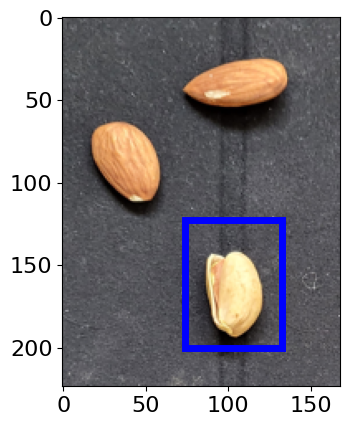

In [123]:
%matplotlib inline
boxes_resized = []
all_boxes_resized = []
fig, ax = plt.subplots(1)
ax.imshow(img_to_plot)

plt.tick_params(labelsize=16)
        
#subplot_title=("Test set item: " + str(selected_idx))
#ax.set_title(subplot_title, fontsize = 20)

# Truth boxes
if imgfile == '':
    print(boxes)
    for box in boxes:
        #Af
        box[0] = box[0] * test_set.img_size[0]
        box[2] = box[2] * test_set.img_size[0]
        box[1] = box[1] * test_set.img_size[1]
        box[3] = box[3] * test_set.img_size[1]
        
        # Og
        #box[0] = box[0] * test_set.img_size[1]
        #box[2] = box[2] * test_set.img_size[1]
        #box[1] = box[1] * test_set.img_size[0]
        #box[3] = box[3] * test_set.img_size[0]
        
    boxes_resized = boxes
    for b in range(len(boxes)):
        bb = boxes_resized[b]
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                edgecolor='r', facecolor="none")
        ax.add_patch(rect)
        
# Predicted boxes
for pbox in all_images_boxes:
    for i in range (pbox.shape[0]):
        #Af
        pbox[i][0] = pbox[i][0] * test_set.img_size[0]
        pbox[i][2] = pbox[i][2] * test_set.img_size[0]
        pbox[i][1] = pbox[i][1] * test_set.img_size[1]
        pbox[i][3] = pbox[i][3] * test_set.img_size[1]
        #Og
        #pbox[i][0] = pbox[i][0] * test_set.img_size[1]
        #pbox[i][2] = pbox[i][2] * test_set.img_size[1]
        #pbox[i][1] = pbox[i][1] * test_set.img_size[0]
        #pbox[i][3] = pbox[i][3] * test_set.img_size[0]

all_boxes_resized = all_images_boxes
print(all_boxes_resized)
detected_labels = [val.item() for val in all_images_labels[0]]
for b in range(len(all_boxes_resized[0])):
    if(detected_labels[b] != 0):
        bb = all_boxes_resized[0][b].detach().cpu().numpy()
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=5,
                                edgecolor='b', facecolor="none")
        
        #ax.text(bb[0],(bb[1]), detected_labels[b], verticalalignment='center', color='white', fontsize=18, weight='bold')
        ax.add_patch(rect)    
plt.show()